In [1]:
from simulation import Simulation
import random
import numpy as np

from torchvision.transforms import v2 as transforms

# Important for simulation to run inline
%matplotlib ipympl

c:\Users\pjdeb\Anaconda3\envs\dsaie\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\pjdeb\Anaconda3\envs\dsaie\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

# Create a pipeline

In [2]:
class AugmentationPipeline():
    def __init__(self):
        self.fliph = random.randint(0, 1)
        self.flipv = random.randint(0, 1)
        self.rotate = [0,90,180,270][random.randint(0, 3)]

        # Define the transformation pipeline with flipping and rotation
        self.transformation_pipeline_2D = transforms.Compose([transforms.RandomRotation(degrees=self.rotate),
                                                      transforms.RandomHorizontalFlip(p=self.fliph),
                                                      transforms.RandomVerticalFlip(p=self.flipv)])

    def transform_2D(self, data):
        """
        Transformation of 2D data. Input:
        data: 2D array
        """
        return self.transformation_pipeline_2D(data)

    def transform_3D(self, data):
        """
        Transformation of gridded vector data. Input:
        data: 3D array --> 2D grid with a vector defined at each point.
        """
        # Step 1: transform the data similarly to 2D
        aug_data1 = self.transformation_pipeline_2D(data)

        # Step 2: rotate the vectors
        # The rotation theorem was obtained from https://matthew-brett.github.io/teaching/rotation_2d.html
        aug_data2 = np.zeros(aug_data1.shape)
        aug_data2[:,:,0] = aug_data1[:,:,0] * np.cos(self.rotate) - aug_data1[:,:,1] * np.sin(self.rotate)
        aug_data2[:,:,1] = aug_data1[:,:,0] * np.sin(self.rotate) + aug_data1[:,:,1] * np.cos(self.rotate)

        return aug_data2

In [3]:
number_grids = 64
save_folder = "../data/raw_datasets"
sim = 42

topo = np.loadtxt(f"{save_folder}\\DEM\\DEM_{sim}.txt")[:, 2].reshape(number_grids,number_grids)
wd = np.loadtxt(f"{save_folder}\\WD\\WD_{sim}.txt").reshape(-1,number_grids,number_grids)
vx = np.loadtxt(f"{save_folder}\\VX\\VX_{sim}.txt").reshape(-1,number_grids,number_grids)
vy = np.loadtxt(f"{save_folder}\\vy\\vy_{sim}.txt").reshape(-1,number_grids,number_grids)

test_sim = Simulation(topo, wd, vx, vy)

In [4]:
test_pipeline = AugmentationPipeline()

wd_aug = np.zeros(wd.shape)
vx_aug = np.zeros(vx.shape)
vy_aug = np.zeros(vy.shape)

topo_aug = test_pipeline.transform_2D(topo)

for i in range(test_sim.wd.shape[0]):

    wd, vx, vy = test_sim.return_timestep(i)

    vxvy = np.zeros((vx.shape[0], vx.shape[1], 2))
    vxvy[:,:,0] = vx
    vxvy[:,:,1] = vy

    wd_aug[i] = test_pipeline.transform_2D(wd)
    vxvy_aug = test_pipeline.transform_3D(vxvy)

    vx_aug[i] = vxvy_aug[:,:,0]
    vy_aug[i] = vxvy_aug[:,:,1]

aug_sim = Simulation(topo_aug, wd_aug, vx_aug, vy_aug)

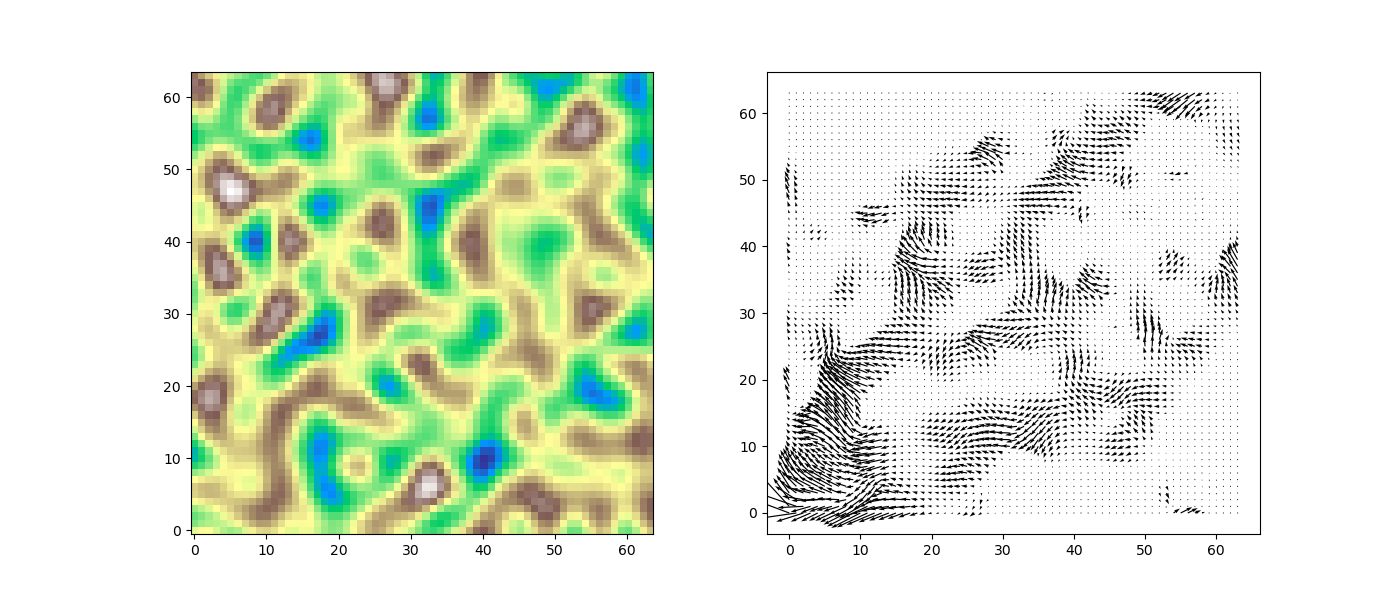

In [5]:
# Test vector plot
fig = aug_sim.plot_vector(-1)

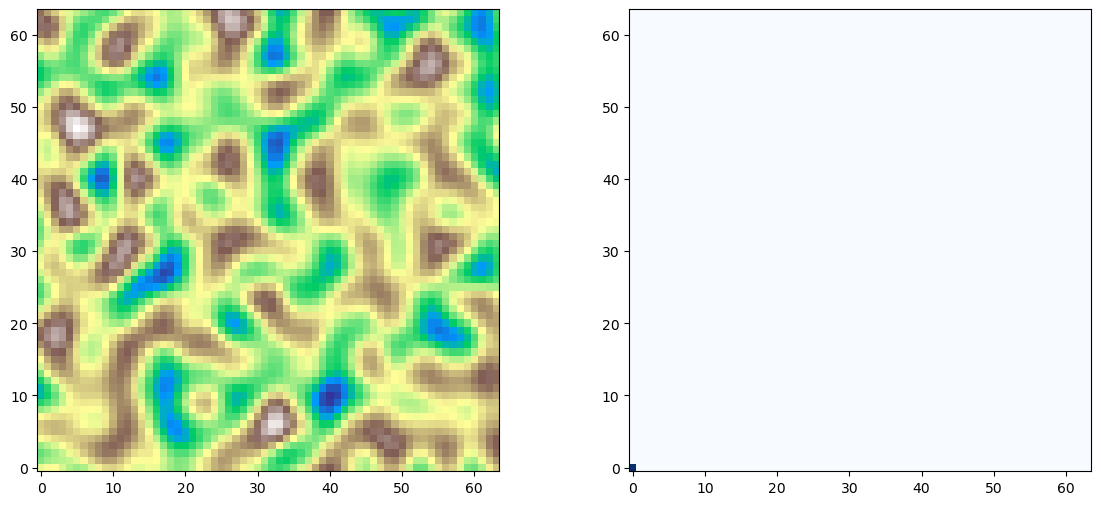

In [10]:
# Test animation
ani = aug_sim.plot_animation()

In [ ]:
def augment_data(simulation, pipeline):
    """
    simulation: instance of simulation class
    pipeline: transformation pipeline

    returns: a new simulation object that was transformed through the pipeline.
    """
    topo_aug = pipeline(simulation.topography)
    wd_aug = pipeline(simulation.wd)
    vx_aug = pipeline(simulation.vx)
    vy_aug = pipeline(simulation.vy)


    aug_simulation = Simulation(topo_aug, wd_aug, vx_aug, vy_aug)    
    return aug_simulation